In [71]:
%pylab inline
from pyspark.sql.types import *
from datetime import datetime
from pyspark.sql import Row, functions as F
from pyspark.ml.feature import Tokenizer, HashingTF, Binarizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Introduction
In this tutorial, we will use spark.ml to build an ML pipeline using the reddit comment dataset.

We are going to build a model to classify reddit comments as positive or negative based on the content of each comment.



## Read in the Reddit data
#### Reading in this dataset takes approximately 17 minutes. A good time for a coffee.

In [6]:
fields = [StructField("archived", BooleanType(), True),
        StructField("author", StringType(), True),
        StructField("author_flair_css_class", StringType(), True),
        StructField("body", StringType(), True),
        StructField("controversiality", LongType(), True),
        StructField("created_utc", StringType(), True),
        StructField("day", LongType(), True),
        StructField("distinguished", StringType(), True),
        StructField("downs", LongType(), True),
        StructField("edited", StringType(), True),
        StructField("gilded", LongType(), True),
        StructField("id", StringType(), True),
        StructField("link_id", StringType(), True),
        StructField("month", LongType(), True),
        StructField("name", StringType(), True),
        StructField("parent_id", StringType(), True),
        StructField("retrieved_on", LongType(), True),
        StructField("score", LongType(), True),
        StructField("score_hidden", BooleanType(), True),
        StructField("subreddit", StringType(), True),
        StructField("subreddit_id", StringType(), True),
        StructField("ups", LongType(), True),
        StructField("year", LongType(), True)]
rawDF = sqlContext.read.json("s3n://reddit-comments/2009", StructType(fields)).persist(StorageLevel.MEMORY_AND_DISK_SER)

## Selecting a subset of the data
To keep the tutorial fast, we'll just use the reddit.com subreddit comments here. You could easily extend this to a general model for comments across all subreddits.

We clean the data by removing deleted comments and comments that do not have a score. We also cast the columns into the correct datatype for Spark's Transformers.


In [10]:
rawDF.take(5)

[Row(archived=True, author=u'glengyron', author_flair_css_class=None, body=u"Iraq was so many magnitudes worse that it's hard to even fathom some of the hatred and bile spilled on reddit.\n\nTry the basic premise of action for starters: A story about WMD versus 70 or so rockets a day hitting suburbanites?\n\nWar is disgusting nasty business, but a bit of self reflection wouldn't go astray here, I agree.", controversiality=0, created_utc=u'1231417849', day=None, distinguished=None, downs=0, edited=u'false', gilded=0, id=u'c06wio7', link_id=u't3_7o91k', month=None, name=u't1_c06wio7', parent_id=u't1_c06wii3', retrieved_on=1425910136, score=4, score_hidden=False, subreddit=u'Israel', subreddit_id=u't5_2qhvo', ups=4, year=None),
 Row(archived=True, author=u'BobGaffney', author_flair_css_class=None, body=u"&gt;Parker's programs can also produce rudimentary poetry\n\nNo doubt as mind-altering as his books", controversiality=0, created_utc=u'1231417871', day=None, distinguished=None, downs=0,

In [11]:
# Select columns that are needed for the training and testing
# Cast columns to the correct datatype for Transformers
# Only use comments that have been upvoted or downvoted
def cast_col(df, col, cast_type):
    '''
    Function to cast column into datatype for Transformers. 
    The format may seem very un-pythonic but because Spark is written in Scala, 
    the columns are immutable and so we need to create a new temporary column (temp_col)
    '''
    return df.withColumn("temp_col", df[col].cast(cast_type))\
             .drop(col)\
             .withColumnRenamed("temp_col", col)

# filter out comments with no score, comments that are deleted, and only use the reddit.com subreddit comments
filteredDF = rawDF.select("id", "body", "score", "score_hidden", "subreddit")\
                  .filter(rawDF.body != "[deleted]")\
                  .filter(rawDF.score_hidden == False)\
                  .filter(rawDF.subreddit == "reddit.com")
castedDF = cast_col(filteredDF, "score", DoubleType())

print "Sample size: {}".format(castedDF.count())

castedDF.registerTempTable("rc")
query = sqlContext.sql("""
    SELECT score, COUNT(*) as cnt FROM rc
    GROUP BY score
    ORDER BY cnt DESC
    """)
result = query.toPandas()


Sample size: 1806276


In [12]:
result.head()

,score,cnt
0,1,778106
1,2,272886
2,0,171550
3,3,135145
4,4,57187


Let's plot the distribution of comment scores to see what the data looks like:

(0, 800000)

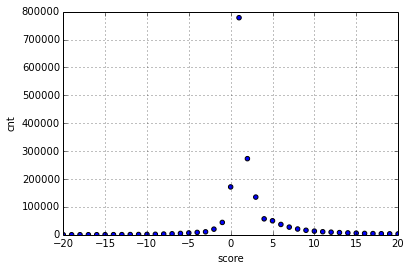

In [9]:
result.plot(x="score", y="cnt", kind="scatter")
plt.xlim([-20,20])
plt.ylim([0, 800000])

Most comments have a score of 1, and the number of comments drops very rapidly on either side of this.

## Creating a labeled dataset
Now that we have cleaned the data, let's create labels for our positive comments and negative comments. 

Since the majority of comments have a score of 0-3, in this example we are going to assume that a comment needs a score < 0 to be a negative comment and > 10 to be a positive comment (10% of the data falls into this classification scheme). 

You probably noticed that conveniently the number of positive comments and the number of negative comments are about equal. A balanced labeled dataset will help simplify training and validating our model.


In [13]:
negativeDF = castedDF.filter(castedDF["score"] < 0)
positiveDF = castedDF.filter(castedDF["score"] > 10)

print negativeDF.count(), positiveDF.count(), castedDF.count()

111414 114957 1806276


## Split into training and testing data
Now let's combine the positive comments and negative comments, and randomly split them into training and testing datasets (80% in the training set, 20% in the testing set). 

We'll put the testing dataset aside for now and use the training dataset to train our model. Once the model is trained, we can use the testing dataset to validate the model.



In [14]:
# Split dataset into training and testing
mergedDF = negativeDF.unionAll(positiveDF)
splitDF = mergedDF.randomSplit([0.8, 0.2])
trainingDF = splitDF[0]
testingDF = splitDF[1]


print "training size: {}".format(trainingDF.count())
print "negative sentiment: {}".format(trainingDF.filter(trainingDF.score<0).count())
print "positive sentiment: {}".format(trainingDF.filter(trainingDF.score>0).count())
print "testing size: {}".format(testingDF.count())


training size: 180883
negative sentiment: 89020
positive sentiment: 91863
testing size: 45488


## Training a model
As features for our model we are going to use the frequency of each word in a comment.

We build an ML pipeline by chaining together the binarizer, tokenizer, hashingTF and logisticregression. Then we  fit the model to the training dataset and make predictions on the testing dataset.


In [40]:
#binarize -- create a column called 'label' that has converted the score into a column 
#that contains a 0 or 1, depending on the threshold variable
binarizer = Binarizer(threshold=0.0, inputCol="score", outputCol="label")
#tokenize the text into individual words
tokenizer = Tokenizer(inputCol="body", outputCol="words")
#hasgingTF - calculate the term frequency and send the resulting values to a column called 'features'

hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
# hashingTF = HashingTF(inputCol='words', outputCol="features")
# ^^ had to do this

#now create a logistic regression
#maxIter is the maximum number of iterations completed when running the fit
#regParam is the regularization strength
lr = LogisticRegression(maxIter=10, regParam=0.01)

#put it all into a pipeline estimator, fit on the training data, and test on the testing data!
pipeline = Pipeline(stages=[binarizer, tokenizer, hashingTF, lr])
model = pipeline.fit(trainingDF)
prediction = model.transform(testingDF)

In [60]:
trainingDF.take(2)

[Row(id=u'achx', body=u'teh internet hate machine? ', score_hidden=False, subreddit=u'reddit.com', score=-1.0),
 Row(id=u'acmp', body=u'FUCK THAT', score_hidden=False, subreddit=u'reddit.com', score=-5.0)]

**`binarizer`**

In [56]:
df1 = binarizer.transform(trainingDF)

col = binarizer.getOutputCol()
print col
df1.select(col).take(2)

label


[Row(label=0.0), Row(label=0.0)]

**`tokenizer`** adds a new column, words to the df

In [3]:
df2 = tokenizer.transform(df1)

print df2.select(tokenizer.getOutputCol()).take(2)

NameError: name 'tokenizer' is not defined

In [2]:
len([u'and', u'israel', u'seems', u'to', u'be', u'working', u'hard', u'to', u'just', u'attack', u'hamas.'])

11

> each element is a list of the words in the body

**`hashingTF`**

In [59]:
df3 = hashingTF.transform(df2)

print df3.select(hashingTF.getOutputCol()).take(2)

[Row(features=SparseVector(262144, {49450: 1.0, 114711: 1.0, 214232: 1.0, 247617: 1.0})), Row(features=SparseVector(262144, {8567: 1.0, 150951: 1.0}))]


> 262144 is 

**`LogisticRegression`**  
Note, it expects 2 columns called `labels` and `features`

In [61]:
_model = lr.fit(df3)
_model

LogisticRegression_4e7db96be3cc2b7e5132

In [64]:
len(_model.weights)

262144

In [62]:
_prediction = model.transform(testingDF)
_prediction

DataFrame[id: string, body: string, score_hidden: boolean, subreddit: string, score: double, label: double, words: array<string>, features: vector, rawPrediction: vector, probability: vector, prediction: double]

## Model validation
### Let's check how well we did:

In [67]:
evaluator = BinaryClassificationEvaluator() # the default metric is the area under the RoC curve
train_RoC = evaluator.evaluate(_model.transform(df3))
# test_RoC = evaluator.evaluate(_model.transform(testingDF))

print "The area under the RoC curve for the training set is {} and for the test set is {}".format(train_RoC, 'na')

The area under the RoC curve for the training set is 0.974188576956 and for the test set is na


In [68]:
evaluator = BinaryClassificationEvaluator() # the default metric is the area under the RoC curve
train_RoC = evaluator.evaluate(model.transform(trainingDF))
test_RoC = evaluator.evaluate(model.transform(testingDF))

print "The area under the RoC curve for the training set is {} and for the test set is {}".format(train_RoC, test_RoC)

The area under the RoC curve for the training set is 0.974188576956 and for the test set is 0.609057192501


### Let's also explore the errors

In [17]:
selected = prediction.select("id", "body", "prediction", "label")
positive_score_rate = binarizer.transform(mergedDF).map(lambda r: r.label).mean()

def typeI_II(row):
    if row.prediction == 0 and row.label == 0:
        return Row(error_type="true_neg", cnt=1)
    elif row.prediction == 0 and row.label == 1:
        return Row(error_type="false_neg", cnt=1)
    elif row.prediction == 1 and row.label == 0:
        return Row(error_type="false_pos", cnt=1)
    else:
        return Row(error_type="true_pos", cnt=1)

typeI_II_DF = selected.map(lambda r: typeI_II(r)).toDF()
type_error_pd = typeI_II_DF.groupBy("error_type")\
                           .sum("cnt")\
                           .withColumnRenamed("SUM(cnt)", "cnt").toPandas()

type_error_pd["tot"] = type_error_pd["cnt"].sum(axis=0)
type_error_pd["perc"] = type_error_pd["cnt"]/type_error_pd["tot"]
print type_error_pd
print "percentage of comments with positive score in full set: {0:.2f}".format(positive_score_rate)



  error_type    cnt    tot      perc
0   true_pos  13662  45488  0.300343
1  false_neg   9432  45488  0.207351
2   true_neg  12863  45488  0.282778
3  false_pos   9531  45488  0.209528

[4 rows x 4 columns]
percentage of comments with positive score in full set: 0.51


## Task 1: Based on the training and test area under RoC, we've really overfit! Consider why. Which other models or analysis steps do we need?
Check into the elasticNetParam option to determine what type of regularlization we have used in our default model. 
Additionally, one could consider trying a Naive Bayes model, or using the pyspark.ml.feature.IDF transformer, or removing stopwords.

### We could also tune the hyperparameters using cross-validation:
(this takes a while)

In [69]:
#Create a grid of hyperparameters - careful, this could take a very long time to run with many points in the grid!
lr_grid = LogisticRegression()
pipeline = Pipeline(stages=[binarizer, tokenizer, hashingTF, lr_grid])

grid = ParamGridBuilder()\
        .baseOn({lr_grid.labelCol: 'label'})\
        .addGrid(lr_grid.regParam, [0.01, 0.1])\
        .addGrid(lr_grid.elasticNetParam, [0.5,0.75])\
        .addGrid(lr_grid.maxIter, [1, 2])\
        .build()
    
print 'optimized over a grid of {} parameter combinations'.format(len(grid))
evaluator = BinaryClassificationEvaluator() # the default is the area under the RoC curve
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=grid, evaluator=evaluator, numFolds=4)
cvModel = cv.fit(trainingDF)


optimized over a grid of 8 parameter combinations


In [70]:
print evaluator.evaluate(cvModel.transform(trainingDF))
print evaluator.evaluate(cvModel.transform(testingDF))

0.635134903875
0.628536118648


#### We've reduced the overfitting and also have a simple model that performs a bit better than random